# Plant Disease Classification Model

This notebook demonstrates the complete ML pipeline for plant disease classification using the PlantVillage dataset.


In [28]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Sklearn for evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


Libraries imported successfully!
TensorFlow version: 2.20.0


## 1. Data Acquisition and Exploration


In [29]:
# Set data paths
BASE_DIR = Path('../')
TRAIN_DIR = BASE_DIR / 'data' / 'train'
TEST_DIR = BASE_DIR / 'data' / 'test'
MODEL_DIR = BASE_DIR / 'models'
MODEL_DIR.mkdir(exist_ok=True)

# Get class names
class_names = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"\nFirst 10 classes: {class_names[:10]}")
print(f"\nLast 10 classes: {class_names[-10:]}")


Number of classes: 38

First 10 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight']

Last 10 classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [30]:
# Count images per class
train_counts = {}
test_counts = {}

for class_name in class_names:
    train_path = TRAIN_DIR / class_name
    test_path = TEST_DIR / class_name
    
    train_images = list(train_path.glob('*.JPG')) + list(train_path.glob('*.jpg')) + list(train_path.glob('*.png'))
    test_images = list(test_path.glob('*.JPG')) + list(test_path.glob('*.jpg')) + list(test_path.glob('*.png'))
    
    train_counts[class_name] = len(train_images)
    test_counts[class_name] = len(test_images)

# Create DataFrame for visualization
df_counts = pd.DataFrame({
    'Class': class_names,
    'Train': [train_counts[c] for c in class_names],
    'Test': [test_counts[c] for c in class_names]
})
df_counts['Total'] = df_counts['Train'] + df_counts['Test']

print(f"Total training images: {df_counts['Train'].sum()}")
print(f"Total test images: {df_counts['Test'].sum()}")
print(f"\nClass distribution (top 10):")
print(df_counts.nlargest(10, 'Total')[['Class', 'Train', 'Test']])


Total training images: 43428
Total test images: 10876

Class distribution (top 10):
                                            Class  Train  Test
15       Orange___Haunglongbing_(Citrus_greening)   4405  1102
35         Tomato___Tomato_Yellow_Leaf_Curl_Virus   4285  1072
24                              Soybean___healthy   4072  1018
16                         Peach___Bacterial_spot   1837   460
28                        Tomato___Bacterial_spot   1701   426
30                           Tomato___Late_blight   1526   382
25                        Squash___Powdery_mildew   1468   367
32                    Tomato___Septoria_leaf_spot   1416   355
33  Tomato___Spider_mites Two-spotted_spider_mite   1340   336
3                                 Apple___healthy   1316   329


## 2. Data Preprocessing


In [31]:
# Image parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Only rescale for validation/test (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    str(TRAIN_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    str(TEST_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")


Found 43429 images belonging to 38 classes.
Found 10876 images belonging to 38 classes.
Training samples: 43429
Test samples: 10876
Number of classes: 38


## 3. Model Creation


In [32]:
# Use transfer learning with MobileNetV2 (lightweight and fast)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model initially
base_model.trainable = False

# Add custom classification head
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Model Training


In [33]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    str(MODEL_DIR / 'plant_disease_model.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = test_generator.samples // BATCH_SIZE

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")


Steps per epoch: 1357
Validation steps: 339


# Plant Disease Classification Model

This notebook demonstrates the complete ML pipeline for plant disease classification using the PlantVillage dataset.


## Training Results Interpretation

Based on your training output, here's what the results mean:


In [34]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Sklearn for evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")


Libraries imported successfully!
TensorFlow version: 2.20.0


## 1. Data Acquisition and Exploration


In [35]:
# Set data paths
BASE_DIR = Path('../')
TRAIN_DIR = BASE_DIR / 'data' / 'train'
TEST_DIR = BASE_DIR / 'data' / 'test'
MODEL_DIR = BASE_DIR / 'models'
MODEL_DIR.mkdir(exist_ok=True)

# Get class names
class_names = sorted([d.name for d in TRAIN_DIR.iterdir() if d.is_dir()])
num_classes = len(class_names)

print(f"Number of classes: {num_classes}")
print(f"\nFirst 10 classes: {class_names[:10]}")
print(f"\nLast 10 classes: {class_names[-10:]}")


Number of classes: 38

First 10 classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight']

Last 10 classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


In [36]:
# Count images per class
train_counts = {}
test_counts = {}

for class_name in class_names:
    train_path = TRAIN_DIR / class_name
    test_path = TEST_DIR / class_name
    
    train_images = list(train_path.glob('*.JPG')) + list(train_path.glob('*.jpg')) + list(train_path.glob('*.png'))
    test_images = list(test_path.glob('*.JPG')) + list(test_path.glob('*.jpg')) + list(test_path.glob('*.png'))
    
    train_counts[class_name] = len(train_images)
    test_counts[class_name] = len(test_images)

# Create DataFrame for visualization
df_counts = pd.DataFrame({
    'Class': class_names,
    'Train': [train_counts[c] for c in class_names],
    'Test': [test_counts[c] for c in class_names]
})
df_counts['Total'] = df_counts['Train'] + df_counts['Test']

print(f"Total training images: {df_counts['Train'].sum()}")
print(f"Total test images: {df_counts['Test'].sum()}")
print(f"\nClass distribution (top 10):")
print(df_counts.nlargest(10, 'Total')[['Class', 'Train', 'Test']])


Total training images: 43428
Total test images: 10876

Class distribution (top 10):
                                            Class  Train  Test
15       Orange___Haunglongbing_(Citrus_greening)   4405  1102
35         Tomato___Tomato_Yellow_Leaf_Curl_Virus   4285  1072
24                              Soybean___healthy   4072  1018
16                         Peach___Bacterial_spot   1837   460
28                        Tomato___Bacterial_spot   1701   426
30                           Tomato___Late_blight   1526   382
25                        Squash___Powdery_mildew   1468   367
32                    Tomato___Septoria_leaf_spot   1416   355
33  Tomato___Spider_mites Two-spotted_spider_mite   1340   336
3                                 Apple___healthy   1316   329


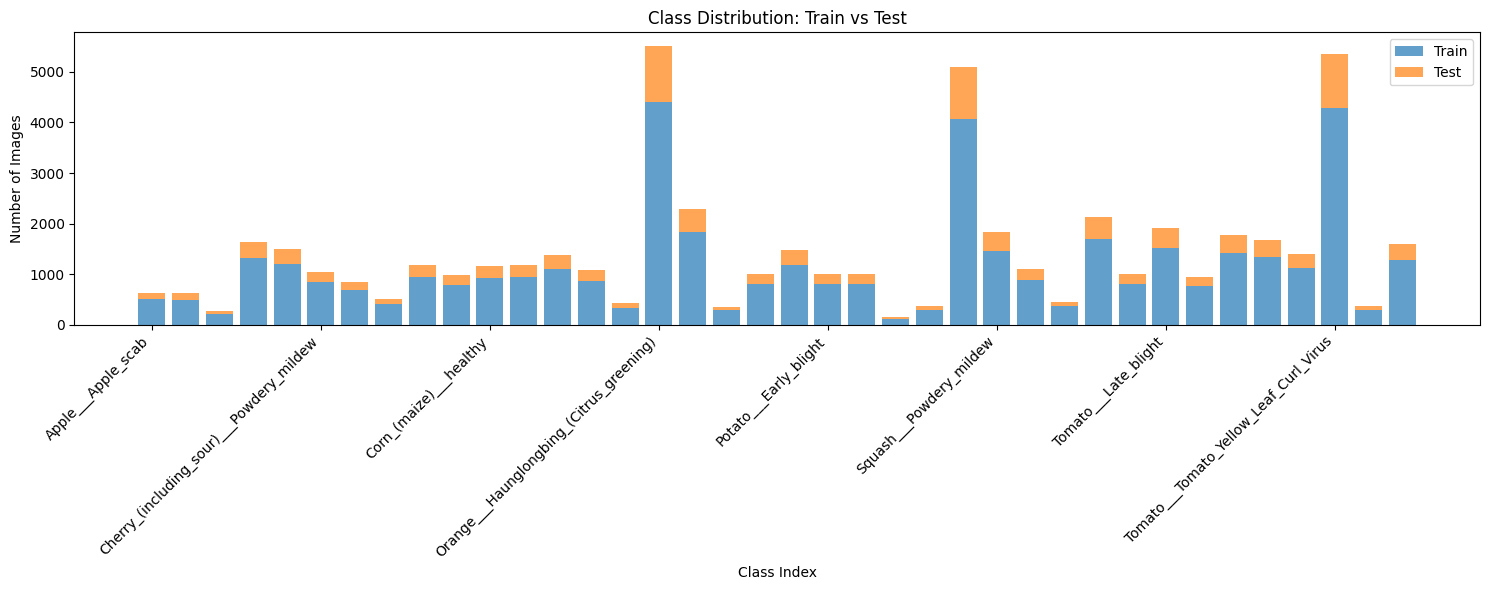

In [37]:
# Visualize class distribution
plt.figure(figsize=(15, 6))
plt.bar(range(len(df_counts)), df_counts['Train'], label='Train', alpha=0.7)
plt.bar(range(len(df_counts)), df_counts['Test'], bottom=df_counts['Train'], label='Test', alpha=0.7)
plt.xlabel('Class Index')
plt.ylabel('Number of Images')
plt.title('Class Distribution: Train vs Test')
plt.legend()
plt.xticks(range(0, len(df_counts), 5), [class_names[i] for i in range(0, len(df_counts), 5)], rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 2. Data Preprocessing


In [38]:
# Image parameters
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

# Create data generators with augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    fill_mode='nearest'
)

# Only rescale for validation/test (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    str(TRAIN_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    str(TEST_DIR),
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print(f"Number of classes: {train_generator.num_classes}")


Found 43429 images belonging to 38 classes.
Found 10876 images belonging to 38 classes.
Training samples: 43429
Test samples: 10876
Number of classes: 38


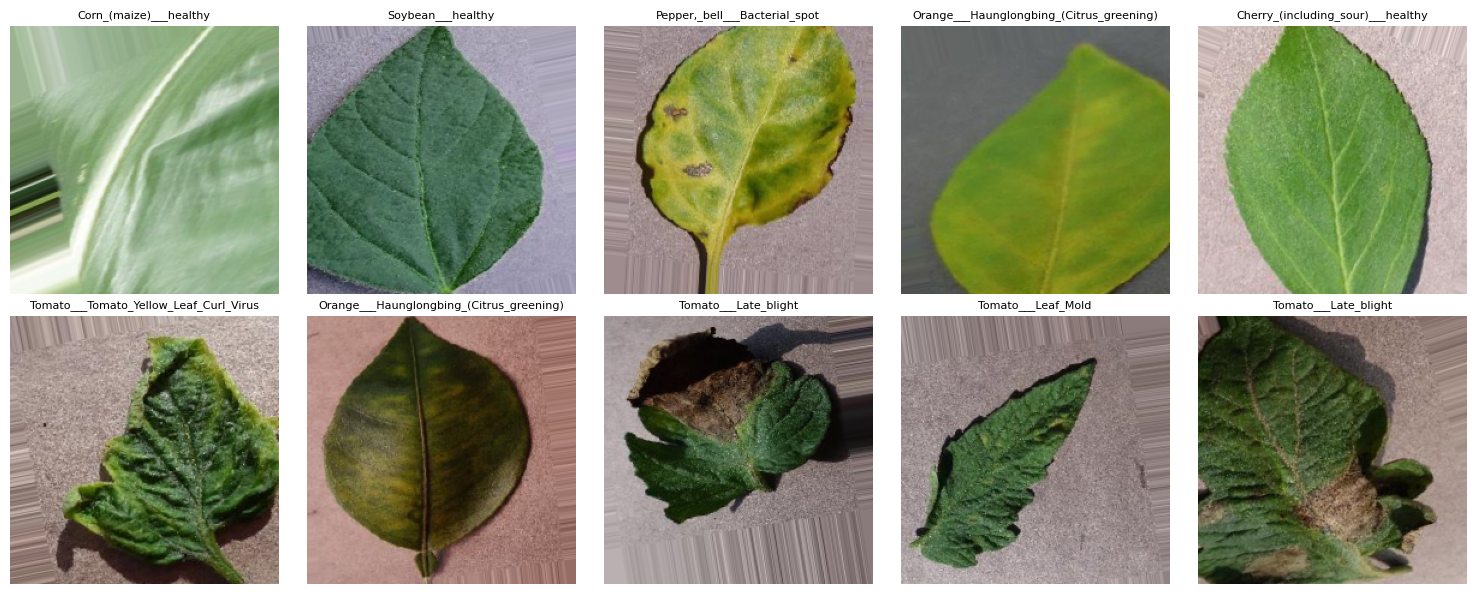

In [39]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i in range(10):
    batch = next(train_generator)
    img = batch[0][0]
    label_idx = np.argmax(batch[1][0])
    label = class_names[label_idx]
    
    axes[i].imshow(img)
    axes[i].set_title(label, fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## 3. Model Creation


In [40]:
# Use transfer learning with MobileNetV2 (lightweight and fast)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model initially
base_model.trainable = False

# Add custom classification head
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 38)             │         4,902 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Model Training


In [43]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    str(MODEL_DIR / 'plant_disease_model.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Calculate steps per epoch (use ceil to ensure all samples are used)
import math
steps_per_epoch = math.ceil(train_generator.samples / BATCH_SIZE)
validation_steps = math.ceil(test_generator.samples / BATCH_SIZE)

print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}")
print(f"Total training samples: {train_generator.samples}")
print(f"Total validation samples: {test_generator.samples}")


Steps per epoch: 1358
Validation steps: 340
Total training samples: 43429
Total validation samples: 10876


In [44]:
# Train the model
history = model.fit(
    train_generator,
    
    epochs=EPOCHS,
    validation_data=test_generator,
    
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)


Epoch 1/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.6592 - loss: 1.2382
Epoch 1: val_accuracy improved from -inf to 0.89656, saving model to ../models/plant_disease_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 675s 496ms/step - accuracy: 0.6593 - loss: 1.2379 - val_accuracy: 0.8966 - val_loss: 0.3177
Epoch 2/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - accuracy: 0.8580 - loss: 0.4399
Epoch 2: val_accuracy improved from 0.89656 to 0.90392, saving model to ../models/plant_disease_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 719s 529ms/step - accuracy: 0.8580 - loss: 0.4399 - val_accuracy: 0.9039 - val_loss: 0.2746
Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step - accuracy: 0.8763 - loss: 0.3772
Epoch 3: val_accuracy improved from 0.90392 to 0.92773, saving model to ../models/plant_disease_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 668s 492ms/step - accuracy: 0.8763 - loss: 0.3772 - val_accuracy: 0.9277 - val_loss: 0.2219
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8866 - loss: 0.3367
Epoch 4: val_accuracy did not improve from 0.92773
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 599s 441ms/step - accuracy: 0.8866 - loss: 0.3367 - val_accuracy: 0.9276 - val_loss: 0.2149
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 481ms/step - accuracy: 0.8872 - loss: 0.3403
Epoch 5: val_accuracy improved from 0.92773 to 0.93968, saving model to ../models/plant_disease_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 776s 572ms/step - accuracy: 0.8872 - loss: 0.3403 - val_accuracy: 0.9397 - val_loss: 0.1848
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8969 - loss: 0.3127
Epoch 6: val_accuracy improved from 0.93968 to 0.94060, saving model to ../models/plant_disease_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 636s 468ms/step - accuracy: 0.8969 - loss: 0.3127 - val_accuracy: 0.9406 - val_loss: 0.1834
Epoch 7/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8953 - loss: 0.3096
Epoch 7: val_accuracy did not improve from 0.94060
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 11337s 8s/step - accuracy: 0.8953 - loss: 0.3096 - val_accuracy: 0.9401 - val_loss: 0.1794
Epoch 8/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.8978 - loss: 0.3112
Epoch 8: val_accuracy did not improve from 0.94060
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 618s 455ms/step - accuracy: 0.8978 - loss: 0.3112 - val_accuracy: 0.9342 - val_loss: 0.1914
Epoch 9/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.9002 - loss: 0.3016
Epoch 9: val_accuracy improved from 0.94060 to 0.94437, saving model to ../models/plant_disease_model.h5


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 611s 450ms/step - accuracy: 0.9002 - loss: 0.3016 - val_accuracy: 0.9444 - val_loss: 0.1688
Epoch 10/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8998 - loss: 0.2965
Epoch 10: val_accuracy did not improve from 0.94437
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 612s 450ms/step - accuracy: 0.8998 - loss: 0.2965 - val_accuracy: 0.9397 - val_loss: 0.1732


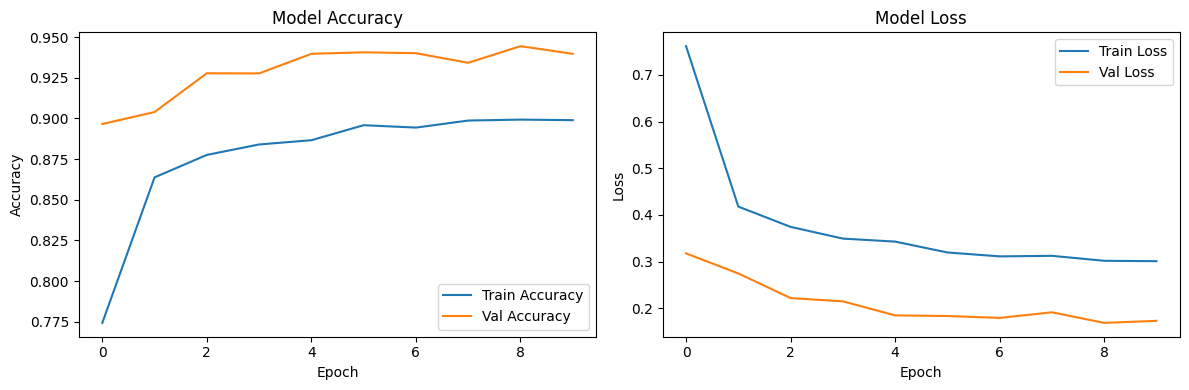

In [45]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Val Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()


## 5. Model Evaluation


In [46]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


340/340 ━━━━━━━━━━━━━━━━━━━━ 113s 331ms/step - accuracy: 0.9597 - loss: 0.1204

Test Loss: 0.1688
Test Accuracy: 0.9444


In [47]:
# Get predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_names))


340/340 ━━━━━━━━━━━━━━━━━━━━ 112s 327ms/step

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.96      0.88      0.92       126
                                 Apple___Black_rot       0.98      0.96      0.97       125
                          Apple___Cedar_apple_rust       0.94      0.93      0.94        55
                                   Apple___healthy       0.94      0.99      0.97       329
                               Blueberry___healthy       1.00      0.97      0.98       301
          Cherry_(including_sour)___Powdery_mildew       0.99      0.97      0.98       211
                 Cherry_(including_sour)___healthy       0.97      1.00      0.98       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.89      0.74      0.81       103
                       Corn_(maize)___Common_rust_       0.96      1.00      0.98       239
          

The model trained for all 10 epochs. Early stopping (patience=3) didn’t trigger because validation accuracy improved at epochs 5, 6, and 9, so training continued. The best model was saved automatically at epoch 9 (94.4% validation accuracy). The model generalizes well: training accuracy is 90.0% and validation accuracy is 94.0%, with validation slightly higher, indicating good generalization rather than overfitting.

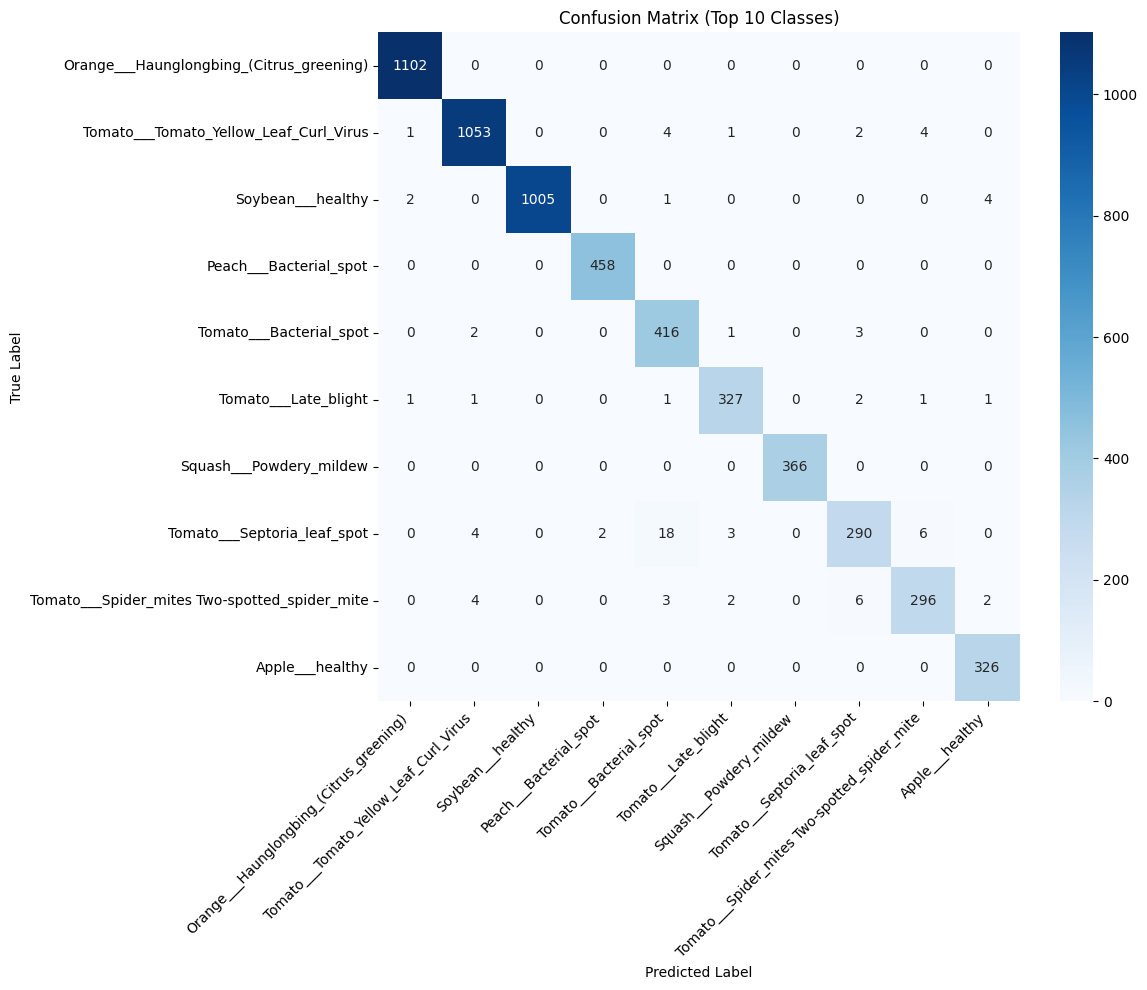

In [48]:
# Confusion Matrix (for top 10 classes to make it readable)
top_10_indices = df_counts.nlargest(10, 'Total').index
top_10_classes = [class_names[i] for i in top_10_indices]
top_10_class_indices = [class_names.index(c) for c in top_10_classes]

# Filter predictions for top 10 classes
mask = np.isin(true_classes, top_10_class_indices)
cm = confusion_matrix(true_classes[mask], predicted_classes[mask], labels=top_10_class_indices)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=top_10_classes, yticklabels=top_10_classes)
plt.title('Confusion Matrix (Top 10 Classes)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


The confusion matrix shows the model's performance on the top 10 plant disease classes. The diagonal (dark blue) represents correct predictions, and off-diagonal cells show misclassifications. Most classes perform well, with Orange Citrus Greening (1,102 correct), Tomato Yellow Leaf Curl Virus (1,053 correct), and Soybean Healthy (1,005 correct) showing high accuracy. Some classes like Orange Citrus Greening, Peach Bacterial Spot, Squash Powdery Mildew, and Apple Healthy have no misclassifications within this subset. The main confusion occurs between similar tomato diseases: Tomato Septoria Leaf Spot is sometimes misclassified as Tomato Late Blight (18 cases), which is expected given their visual similarity. The model demonstrates strong classification performance on these top 10 classes, with most predictions correct and only minor confusion between visually similar disease types.

## 6. Model Testing / Prediction Functions


In [49]:
# Function to predict a single image
def predict_image(image_path, model, class_names, img_size=224):
    """
    Predict the class of a single image
    
    Args:
        image_path: Path to the image file
        model: Trained Keras model
        class_names: List of class names
        img_size: Target image size
    
    Returns:
        predicted_class: Name of predicted class
        confidence: Confidence score
    """
    from tensorflow.keras.preprocessing import image
    
    # Load and preprocess image
    img = image.load_img(image_path, target_size=(img_size, img_size))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    
    # Predict
    predictions = model.predict(img_array, verbose=0)
    predicted_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_idx]
    predicted_class = class_names[predicted_idx]
    
    return predicted_class, confidence

# Test prediction on a sample image
sample_image = list((TEST_DIR / class_names[0]).glob('*.JPG'))[0]
predicted_class, confidence = predict_image(str(sample_image), model, class_names)

print(f"Sample Image: {sample_image.name}")
print(f"True Class: {class_names[0]}")
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.4f}")


Sample Image: 1f6abf22-93fa-48f0-a509-cc3e210f75f0___FREC_Scab 3172.JPG
True Class: Apple___Apple_scab
Predicted Class: Apple___Apple_scab
Confidence: 0.8690


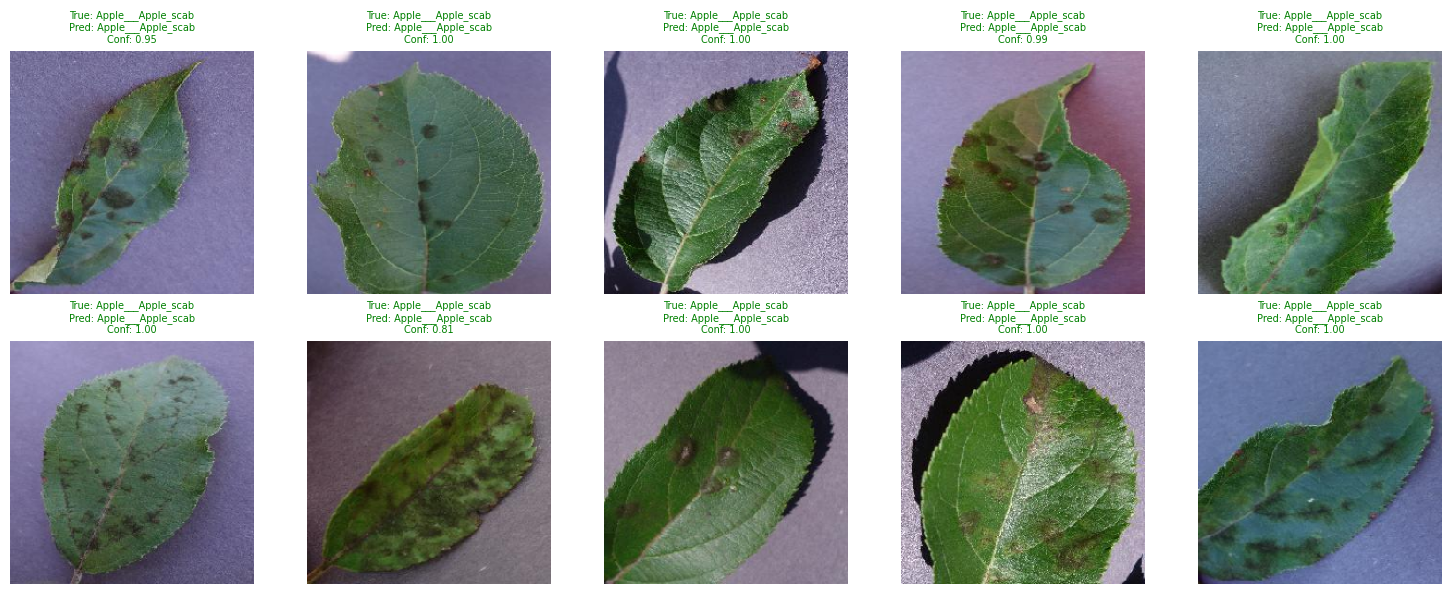

In [ ]:
# Visualize predictions on sample test images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

test_generator.reset()
batch = next(test_generator)

for i in range(10):
    img = batch[0][i]
    true_idx = np.argmax(batch[1][i])
    true_label = class_names[true_idx]
    
    # Predict
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_idx = np.argmax(pred[0])
    pred_label = class_names[pred_idx]
    confidence = pred[0][pred_idx]
    
    axes[i].imshow(img)
    color = 'green' if true_idx == pred_idx else 'red'
    axes[i].set_title(f'True: {true_label[:20]}\nPred: {pred_label[:20]}\nConf: {confidence:.2f}', 
                      fontsize=7, color=color)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


## 7. Save Model

The model has been automatically saved to `models/plant_disease_model.h5` during training.


In [51]:
# Verify model is saved
if (MODEL_DIR / 'plant_disease_model.h5').exists():
    print("✓ Model saved successfully!")
    print(f"Model location: {MODEL_DIR / 'plant_disease_model.h5'}")
else:
    print("✗ Model file not found")


✓ Model saved successfully!
Model location: ../models/plant_disease_model.h5
